### Predicting Vaccine Sentiment on Twitter

In [92]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

%matplotlib inline

from matplotlib.mlab import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

from itertools import cycle
from scipy import interp

from sklearn.metrics import roc_curve
from sklearn.metrics import auc



In [141]:
# define parameters
keyword_frequency_threshold = 0
JSS_Ones_Threshold = 0.008
#JSS_Ones_Threshold = 0.0105
JSS_Zeros_Threshold = .5812
#JSS_Zeros_Threshold = .5811
number_folds = 5
pca_components = 300
total_records = 1099

In [18]:
#import dataset
df = pd.read_csv('vaccines__2017-09-24_to_2017-10-01_labeled.csv', encoding ='latin1')
#save back to csv to resolve encoding issue
df.to_csv('vaccines__2017-09-24_to_2017-10-01_labeled_utf.csv', encoding = 'utf-8')

df.head(n=20)
#get the percentage of 
print(df['Vaccination-Sentiment'].sum() / 1099)

0.5805277525022748


In [19]:
# re-import csv 
df = pd.read_csv('vaccines__2017-09-24_to_2017-10-01_labeled_utf.csv', encoding ='utf-8')
df= df.replace(np.nan,'')
# create target series
Y=df["Vaccination-Sentiment"]



In [20]:
# create feature dataframe with user_description as a column
features = pd.DataFrame()
features['user_description'] = df['user_description'].astype(str)


In [21]:
# remove punctuation, make all lower case, remove and non-alphanumeric values, split the data into a list
features['user_description'] = features['user_description'].apply\
(lambda x:''.join([i for i in x if i not in string.punctuation]))
features['user_description'] = features['user_description'].apply\
(lambda x:''.join([i for i in x if str.isalnum(i) or str.isspace(i)]))
features['user_description'] = features['user_description'].str.lower()

features['user_description'].head(n=150)
features['user_description_list'] = features['user_description'].str.split()



In [22]:
#remove stopwords from the user description

stop = set(['our','and','a','of','for','in','is','that','are','an','to','not','on','with','it','was','the','i','we','my',\
            'you','your','by','all','at','what','be','we','me','about','whom','im','own','but','as','no','us','am','from'\
           'who','do','can','its','if','or','who','dont','out','have','get','so','here','day','twitter','things'\
           'from','when','they','where','without','too','how','where','than','2','3','this','up','just','were','from',\
           'tweets','go','only','being','there','from','like','never','one','find','accounts','web','show','see','way',\
           'over','will','things','their','her','youre','through','yes','2a','cant','la','whats','let','y','u','then','said',\
           'page','been','e','7','t','w','any','others','12','de','buys','commissioning','organizes','yale','easily','français'\
           'she','shes','ucla','o','why','email','didnt','next','including','isnt','high','followback','teamfollowback',\
            'love','health'])

#make a list of the words in the user_description
features['user_description_list'] = features['user_description_list'].apply(lambda x: [item for item in x if item not in stop])
#print(features['user_description_list'])

In [23]:
#return a list of keywords to use as features based on frequency
# (Note: the threshold for a keyword is set to 1 since I ultimately decided to filter out features based on a threshold for
# the JSS index)

s= pd.DataFrame(columns=['user_description_list'])
s['user_description_list']= features['user_description_list'].apply(pd.Series).stack()
s_value = (s['user_description_list'].value_counts())

keyword_df = s['user_description_list'].value_counts().reset_index()
keyword_df.columns=['keyword','count']
keyword_df.head()
keyword_df= keyword_df[lambda df: keyword_df['count']>keyword_frequency_threshold]


print(keyword_df.head())



   keyword  count
0    world     49
1     news     47
2     life     47
3    truth     43
4  science     39


In [24]:
#create dummies from keywords

data = pd.DataFrame()
for key in keyword_df['keyword']:
    data[str(key)] = features['user_description'].str.contains(' ' + str(key) + ' ', case=False).astype(int)

data.head()

,world,news,life,truth,science,wife,writer,people,maga,right,...,houston,fiercely,dinosaur,valar,trumpenomics,pleasures,learnerktm,fix,tae,female
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# try running a Bernoulli and Gaussian Naive Bayes with the original dataset (using entire dataset for training and testing)

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB


# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()
gaussian = GaussianNB()

# Fit our model to the data.
bnb.fit(data, Y)
gaussian.fit(data,Y)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)
y_pred_gauss = gaussian.predict(data)

# Display our results.
print("BernoulliNB: number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (Y != y_pred).sum()
))

# Display our results.
print("GaussianNB: number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (Y != y_pred_gauss).sum()
))

print("Percent Accuracy BNB:", ((1099-158)/1099)*100)
print("Percent Accuracy GNB:", ((1099-150)/1099)*100)

BernoulliNB: number of mislabeled points out of a total 1099 points : 158
GaussianNB: number of mislabeled points out of a total 1099 points : 150
Percent Accuracy BNB: 85.62329390354869
Percent Accuracy GNB: 86.35122838944494


In [29]:
# create training and testing vars for the dataset using a stratified kfold
# test size set to 1/10 of dataset

from sklearn.model_selection import StratifiedShuffleSplit
data_skf = data.values
skf = StratifiedShuffleSplit(n_splits=number_folds,test_size=.1)
skf.get_n_splits(data_skf, Y)
print(skf)
add_mislabeled = 0
for train_index, test_index in skf.split(data_skf,Y):
    X_train, X_test = data_skf[train_index], data_skf[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit our model to the data.
    bnb.fit(X_train, y_train)
    predictions = bnb.predict(X_test)

    # Display our results.
    print("Number of mislabeled points out of a total {} points : {}".format(
        X_test.shape[0],
        (y_test != predictions).sum()
    ))
    add_mislabeled += (y_test != predictions).sum()

print("Average number of mislabeled points: ",add_mislabeled /number_folds)
percent_accuracy = ((110 - (add_mislabeled / number_folds)) / 110)*100
print("Average % accuracy: ", percent_accuracy)

StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.1,
            train_size=None)
Number of mislabeled points out of a total 110 points : 37
Number of mislabeled points out of a total 110 points : 37
Number of mislabeled points out of a total 110 points : 39
Number of mislabeled points out of a total 110 points : 36
Number of mislabeled points out of a total 110 points : 43
Average number of mislabeled points:  38.4
Average % accuracy:  65.0909090909


### Evaluation:
Accuracy drops by 20% for the BNB model when cross-validation used. 

In [66]:
# try running a logistic model 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e4)
fit = lr.fit(data,Y)
#print('Coefficients')
#print(fit.coef_)
#print(fit.intercept_)
pred_y_sklearn = lr.predict(data)

print('\n Accuracy in predicting Vaccination Sentiment')
print(pd.crosstab(pred_y_sklearn,Y))

print('\n Percentage accuracy')
print(lr.score(data,Y)*100)



 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment    0    1
row_0                          
0                      424    0
1                       37  638

 Percentage accuracy
96.6333030027


In [67]:
#from sklearn.model_selection import StratifiedShuffleSplit
data_skf = data.values
skf = StratifiedShuffleSplit(n_splits=number_folds,test_size=.1)
skf.get_n_splits(data_skf, Y)

add_score = 0
for train_index, test_index in skf.split(data_skf,Y):
    X_train, X_test = data_skf[train_index], data_skf[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit our model to the data.
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)

    # Display our results.
    print('\n Accuracy in predicting Vaccination Sentiment')
    print(pd.crosstab(predictions,y_test))
    
    print('\n Percentage accuracy')
    print(lr.score(X_test,y_test))
    add_score += lr.score(X_test,y_test)

average_score = add_score / number_folds
std_array = [0.736363636364,0.654545454545,0.636363636364,0.663636363636,0.581818181818]
print(np.std(std_array))

print("\nAverage of folds:\n",average_score*100)


 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      27  10
1                      19  54

 Percentage accuracy
0.736363636364

 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      24  18
1                      22  46

 Percentage accuracy
0.636363636364

 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      18  15
1                      28  49

 Percentage accuracy
0.609090909091

 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      20  11
1                      26  53

 Percentage accuracy
0.663636363636

 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      26  12
1                      20  52

 Percentage accu

### Evaluation of logistic regression results
Super high accuracy using logistic regression model when entire set used for training and testing. Drops off substantially when cross-validation used

In [152]:
# try a random forest classifier
#try rfc using reduced feature set
rfc = ensemble.RandomForestClassifier()
rfc.fit(data,Y)
score = rfc.score(data,Y)
print(score)

0.949954504095


In [155]:


#for each fold assign it as the test dataset and fit your model on the remaining data
# create training and testing vars
add_score = 0
iteration = 1
for train_index, test_index in skf.split(data_skf,Y):
    X_train, X_test = data_skf[train_index], data_skf[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit our model to the data.
    rfc.fit(X_train,y_train)
    predictions = rfc.predict(X_test)
    print("Result for fold #",iteration)
    print(pd.crosstab(predictions,y_test))
    print(rfc.score(X_test,y_test))
    iteration += 1
    add_score += rfc.score(X_test,y_test)

average_score = add_score / number_folds

print("\nAverage of folds:\n",average_score*100)
    

Result for fold # 1
Vaccination-Sentiment   0   1
row_0                        
0                      13   8
1                      33  56
0.627272727273
Result for fold # 2
Vaccination-Sentiment   0   1
row_0                        
0                      11   9
1                      35  55
0.6
Result for fold # 3
Vaccination-Sentiment   0   1
row_0                        
0                      14  12
1                      32  52
0.6
Result for fold # 4
Vaccination-Sentiment   0   1
row_0                        
0                      15   8
1                      31  56
0.645454545455
Result for fold # 5
Vaccination-Sentiment   0   1
row_0                        
0                      16   6
1                      30  58
0.672727272727

Average of folds:
 62.9090909091


In [157]:
#try using PCA to reduce the dataset

sklearn_pca = PCA(n_components=pca_components)
Y_sklearn = sklearn_pca.fit_transform(data)

pca_components = 30
bnb.fit(Y_sklearn,Y)
lr.fit(Y_sklearn,Y)
rfc.fit(Y_sklearn,Y)
score = cross_val_score(bnb,Y_sklearn,Y,cv=number_folds)
score_lr = cross_val_score(lr,Y_sklearn,Y,cv=number_folds)
score_rfc = cross_val_score(rfc,Y_sklearn,Y,cv=number_folds)
print("Mean Score for BNB with PCA dataset: ",score.mean())
print("Mean Score for LR with PCA dataset: ",score_lr.mean())
print("Mean Score for RFC with PCA dataset: ",score_rfc.mean())

Mean Score for BNB with PCA dataset:  0.595214063401
Mean Score for LR with PCA dataset:  0.642429501737
Mean Score for RFC with PCA dataset:  0.615131717597


### Evaluation of PCA
PCA on the orignal keyword dataset did not work very well regardless of the number of components. I'll try reducing the number of features by calculating the Jaccard Similarity Score and setting a threshold value

### Jaccard Similarity Functions

In [39]:
# create a function that makes variables for J11, J00 (1-J11), J01, J10
#jaccard similarity = size of intersection divided by size of the union
def cont_table(x, Y):
    #a = x_zero + y_zero
    a = (np.where(x + Y == 0,1,0)).sum() 
    #b = x_zero + y_one
    b = (np.where(x - Y== -1,1,0)).sum()
    #c = x_one + y_zero
    c = (np.where(x - Y== 1,1,0)).sum()
   #d = x_one + y_one
    d = (np.where(x + Y == 2,1,0)).sum()
    return (a, b, c, d)

In [40]:
# use the a-d output from cont_table to calculate the jss and inverse jss
def SJS(x, Y):
    a,b,c,d = cont_table(x,Y)
    J1 = b / (a + d + b)
    J2 = d / (b + c + d)
    return (J1, J2)


In [142]:
# Calculate the JSS between each feature and the target 

JSS_values = pd.DataFrame(columns=['column','Zeros_JSS','Ones_JSS'])

# loop through the data running the functions to output a jss
index = 0
for column in data.columns:
        x=data[column]
        J1 = SJS(x,Y)[0]
        J2 = SJS(x,Y)[1]
        df1 = pd.DataFrame({'column':[column],'Zeros_JSS':[J1],'Ones_JSS':[J2]},index=[index])
        index += 1
        frames=[JSS_values, df1]
        JSS_values = pd.concat(frames)

JSS_Features_AntiVaxx_Corr = JSS_values.sort(['Ones_JSS'],ascending=False)
print(JSS_Features_AntiVaxx_Corr.head())

JSS_Features_ProVaxx_Corr = JSS_values.sort(['Zeros_JSS'],ascending=False)



   Ones_JSS  Zeros_JSS  column
3  0.051562   0.551504   truth
0  0.041667   0.561065   world
1  0.036753   0.566421    news
2  0.035549   0.564220    life
7  0.032457   0.566055  people


C:\Users\stace\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\stace\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [144]:
# Create a reduced feature dataframe based on thresholds for JSS

# create a series for x=1 and y=1 high similiarity        
JSS_Features_AntiVaxx_Corr = JSS_Features_AntiVaxx_Corr.loc[JSS_Features_AntiVaxx_Corr['Ones_JSS'] > JSS_Ones_Threshold]
#JSS_Features_Ones_Corr = JSS_Features_Ones_Corr.sort(JSS_Features_Ones_Corr['Ones_JSS'], ascending = False)
#print (JSS_Features_Ones_Corr)
# create a series for x=0, y=1 similarity
JSS_Features_ProVaxx_Corr = JSS_Features_ProVaxx_Corr.loc[JSS_Features_ProVaxx_Corr['Zeros_JSS'] > JSS_Zeros_Threshold]

## Create a New Keyword set based on the 2 thresholds
Keywords_Pro_Vaxx = list(JSS_Features_ProVaxx_Corr['column'])
print('Words Least Present When Target = 1: ',Keywords_Pro_Vaxx,'\n')
Keywords_Against_Vaxx = list(JSS_Features_AntiVaxx_Corr['column'])
print('Words Most Present When Target = 1: ',Keywords_Against_Vaxx,'\n')

Keywords_Pro_Set = set(Keywords_Pro_Vaxx)
Keywords_Against_Set = set(Keywords_Against_Vaxx)
Keywords_Against_Not_Pro = Keywords_Against_Set - Keywords_Pro_Set

Keywords_Combined = Keywords_Pro_Vaxx + list(Keywords_Against_Not_Pro)

Words Least Present When Target = 1:  ['science', 'care', 'services', 'community', 'public', 'views', 'account', 'disease', 'development', 'updates', 'writer', 'nurse', 'mum', 'retweets', 'diseases', 'scientist', 'policy', 'across', 'ill', 'veterans', 'nursing', 'department', 'mental', 'immunization', 'write', 'geek', 'general', 'office', 'gp', 'improve', 'opinions', 'quality', 'wife', 'better', 'kids', 'blogger', 'foundation', 'california', 'committed', 'avid', 'tv', 'prevent', 'understanding', 'pharmacy', 'primary', 'phd', 'pediatrician', 'connecting', 'women', 'vaccineswork', 'economics', 'analysis', 'lawyer', 'data', 'ccg', 'self', 'former', 'please', 'organises', 'irish', 'hospital', 'videos', 'officer', 'mine', 'book', 'software', 'edge', 'patients', 'benefits', 'decision', 'correspondent', 'practices', 'second', 'globalhealth', 'student', 'state', 'point', 'child', 'professional', 'friend', 'some', 'county', 'reader', 'med', 'civil', 'found', 'school', 'would', 'engineer', 'heal

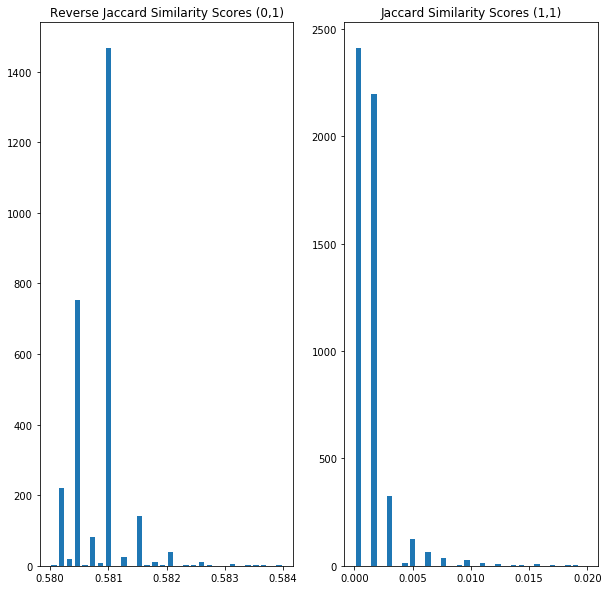

In [55]:
# plot the range of Jaccard Similarity/Reverse Jaccard Similarity Scores to inform cutoffs

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
range_x = (.58,.584)
hist, bins = np.histogram(JSS_values['Zeros_JSS'], bins=30, range = range_x)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.title("Reverse Jaccard Similarity Scores (0,1)")
plt.bar(center, hist, align='center', width=width)

plt.subplot(1,2,2)
range_x = (0,.02)
hist, bins = np.histogram(JSS_values['Ones_JSS'], bins=30,range = range_x)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("Jaccard Similarity Scores (1,1)")

plt.show()

In [145]:
# create a new dataset based on the JSS values

features_JSS = pd.DataFrame()

for key in Keywords_Combined:
    features_JSS[str(key)] = features['user_description'].str.contains(' ' + str(key) + ' ', case=False).astype(int)
    
features_JSS.head(n=20)


,science,care,services,community,public,views,account,disease,development,updates,...,man,truth,social,every,know,rights,change,vaccine,america,political
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# features dropped based on the JSS analysis features to features (below)
#features_JSS.drop(['high'],axis=1)
#features_JSS.drop(['love'],axis=1)

### BNB using the reduced dataset

In [146]:
# Instantiate our model and store it in a new variable.
bnb_JSS = BernoulliNB()

bnb_JSS.fit(features_JSS,Y)
y_pred_JSS_bnb = bnb_JSS.predict(features_JSS)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    features_JSS.shape[0],
    (Y != y_pred_JSS_bnb).sum()
))

correctlylabeled = total_records - (Y != y_pred_JSS_bnb).sum()
print('% Accurately Predicted: ',(correctlylabeled /total_records ) * 100)

## Note: cutting down from 270 to 168 columns had little impact on the accuracy of the naive bayes model


Number of mislabeled points out of a total 1099 points : 231
% Accurately Predicted:  78.9808917197


In [147]:
#from sklearn.model_selection import StratifiedShuffleSplit
data_JSS_skf = features_JSS.values
skf_JSS = StratifiedShuffleSplit(n_splits=number_folds,test_size=.1)
skf_JSS.get_n_splits(data_JSS_skf, Y)

add_mislabeled = 0

for train_index, test_index in skf.split(data_JSS_skf,Y):
    X_train, X_test = data_JSS_skf[train_index], data_JSS_skf[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit our model to the data.
    bnb_JSS.fit(X_train, y_train)
    predictions = bnb_JSS.predict(X_test)

    # Display our results.
    print("Number of mislabeled points out of a total {} points : {}".format(
        X_test.shape[0],
        (y_test != predictions).sum()
    ))
    add_mislabeled += (y_test != predictions).sum()
    

print("Average number of mislabeled points: ",add_mislabeled /number_folds)

percent_accuracy = ((110 - (add_mislabeled / number_folds)) / 110)*100
print("Average % accuracy: ", percent_accuracy)


Number of mislabeled points out of a total 110 points : 30
Number of mislabeled points out of a total 110 points : 24
Number of mislabeled points out of a total 110 points : 31
Number of mislabeled points out of a total 110 points : 28
Number of mislabeled points out of a total 110 points : 27
Average number of mislabeled points:  28.0
Average % accuracy:  74.5454545455


In [148]:
# use sklearn for logistic model to see if regularization coefficient can increase the accuracy
#from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression(C=1e4)
fit = lr.fit(features_JSS,Y)
#print('Coefficients')
#print(fit.coef_)
#print(fit.intercept_)
pred_y_lr_jss = lr.predict(features_JSS)

print('\n Accuracy in predicting Vaccination Sentiment')
print(pd.crosstab(pred_y_lr_jss,Y))

print('\n Percentage accuracy')
print(lr.score(features_JSS,Y)*100)




 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment    0    1
row_0                          
0                      338   14
1                      123  624

 Percentage accuracy
87.534121929


In [149]:
#run cross-validated lr on reduced feature set
add_score = 0
for train_index, test_index in skf.split(data_JSS_skf,Y):
    X_train, X_test = data_JSS_skf[train_index], data_JSS_skf[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit our model to the data.
    lr.fit(X_train, y_train)
    lr_predictions = lr.predict(X_test)

    # Display our results.
    print('\n Accuracy in predicting Vaccination Sentiment')
    print(pd.crosstab(lr_predictions,y_test))
    
    print('\n Percentage accuracy')
    print(lr.score(X_test,y_test))
    add_score += lr.score(X_test,y_test)

average_score = add_score / number_folds

print("\nAverage of folds:\n",average_score*100)


 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      30   5
1                      16  59

 Percentage accuracy
0.809090909091

 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      29   8
1                      17  56

 Percentage accuracy
0.772727272727

 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      26   7
1                      20  57

 Percentage accuracy
0.754545454545

 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      29  11
1                      17  53

 Percentage accuracy
0.745454545455

 Accuracy in predicting Vaccination Sentiment
Vaccination-Sentiment   0   1
row_0                        
0                      24   6
1                      22  58

 Percentage accu

In [160]:
#try rfc using reduced feature set
rfc_JSS = ensemble.RandomForestClassifier()
rfc_JSS.fit(features_JSS,Y)
score = rfc_JSS.score(features_JSS,Y)
print(score)

#Note: simplifying the dataset based on JSS scores improved the average RFC output

0.890809827116


In [162]:
#for each fold assign it as the test dataset and fit your model on the remaining data
# create training and testing vars
add_score = 0
iteration = 1
for train_index, test_index in skf.split(data_JSS_skf,Y):
    X_train, X_test = data_JSS_skf[train_index], data_JSS_skf[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit our model to the data.
    rfc_JSS.fit(X_train,y_train)
    predictions = rfc_JSS.predict(X_test)
    print("Result for fold #",iteration)
    print(pd.crosstab(predictions,y_test))
    print(rfc_JSS.score(X_test,y_test))
    iteration += 1
    add_score += rfc_JSS.score(X_test,y_test)

average_score = add_score / number_folds

print("\nAverage of folds:\n",average_score*100)
    

Result for fold # 1
Vaccination-Sentiment   0   1
row_0                        
0                      21   3
1                      25  61
0.745454545455
Result for fold # 2
Vaccination-Sentiment   0   1
row_0                        
0                      24  13
1                      22  51
0.681818181818
Result for fold # 3
Vaccination-Sentiment   0   1
row_0                        
0                      16   6
1                      30  58
0.672727272727
Result for fold # 4
Vaccination-Sentiment   0   1
row_0                        
0                      25   8
1                      21  56
0.736363636364
Result for fold # 5
Vaccination-Sentiment   0   1
row_0                        
0                      15   7
1                      31  57
0.654545454545

Average of folds:
 69.8181818182


In [120]:
#try using PCA to reduce the dataset

sklearn_pca = PCA(n_components=pca_components)
Y_sklearn = sklearn_pca.fit_transform(features_JSS)

pca_components = 100
bnb.fit(Y_sklearn,Y)
lr.fit(Y_sklearn,Y)
rfc_JSS.fit(Y_sklearn,Y)

score = cross_val_score(bnb,Y_sklearn,Y,cv=number_folds)
score_lr = cross_val_score(lr,Y_sklearn,Y,cv=number_folds)
score_rfc = cross_val_score(rfc_JSS,Y_sklearn,Y,cv=number_folds)

print("Mean Score for BNB with PCA dataset: ",score.mean())
print("Mean Score for LR with PCA dataset: ",score_lr.mean())
print("Mean Score for RFC with PCA dataset: ",score_rfc.mean())


Mean Score for BNB with PCA dataset:  0.580569170287
Mean Score for LR with PCA dataset:  0.687921594924
Mean Score for RFC with PCA dataset:  0.734285832352


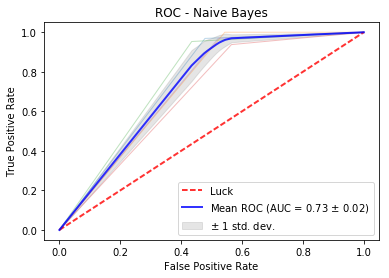

In [93]:
# Plot ROC for bnb output

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train_index, test_index in skf.split(data_JSS_skf,Y):
    X_train, X_test = data_JSS_skf[train_index], data_JSS_skf[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit our model to the data.
    bnb_JSS.fit(X_train, y_train)
    predictions = bnb_JSS.predict(X_test)

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)
             #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

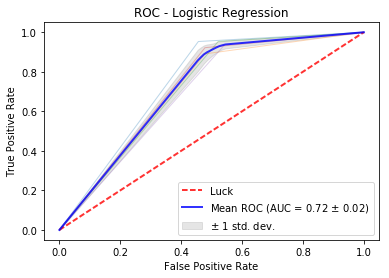

In [94]:
# plot ROC for Logistic Regression
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train_index, test_index in skf.split(data_JSS_skf,Y):
    X_train, X_test = data_JSS_skf[train_index], data_JSS_skf[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit our model to the data.
    lr.fit(X_train, y_train)
    lr_predictions = lr.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, lr_predictions)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)
             #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [100]:
# run JSS to compare all features to each other - possibly further reduce feature set

JSS_values_All = pd.DataFrame(columns=['column','comp_column','Zeros_JSS','Ones_JSS'])

# loop through the data running the functions to output a jss
index = 0
for column in features_JSS.columns:
    for comp_column in features_JSS.columns:
            x=features_JSS[column]
            y=features_JSS[comp_column]
            J1 = SJS(x,y)[0]
            J2 = SJS(x,y)[1]
            df2 = pd.DataFrame({'column':[column],'comp_column':[comp_column],'Zeros_JSS':[J1],'Ones_JSS':[J2]},index=[index])
            index += 1
            frames=[JSS_values_All, df2]
            JSS_values_All = pd.concat(frames)



In [101]:
# save the output of the feature to feature JSS so it can be inputed without re-running the cell above
JSS_values_All.to_csv('vaccines_jss_values.csv')
JSS_values_All.head()

,Ones_JSS,Zeros_JSS,column,comp_column
0,1.000000,0.000000,science,science
1,0.000000,0.015873,science,care
2,0.000000,0.010271,science,services
3,0.000000,0.007470,science,community
4,0.047619,0.013048,science,public


In [108]:

JSS_Features_Sorted = JSS_values_All[JSS_values_All.Ones_JSS != 1]
JSS_Features_Sorted = JSS_Features_Sorted[JSS_Features_Sorted.Zeros_JSS != 1]

JSS_Features_Sorted = JSS_Features_Sorted.sort_values(['Ones_JSS'],ascending = False)


In [109]:
JSS_Features_Sorted = JSS_Features_Sorted.sort_values(['Zeros_JSS'],ascending = False)
JSS_Features_Sorted.head(n=10)


,Ones_JSS,Zeros_JSS,column,comp_column
91956,0.0,0.036551,life,news
82850,0.0,0.036483,people,news
83164,0.0,0.036178,make,news
91014,0.0,0.036178,music,news
88816,0.0,0.036145,mom,news
86618,0.0,0.036111,god,news
80652,0.0,0.036111,maga,news
93526,0.0,0.036111,mother,news
94468,0.0,0.036078,medical,news
96038,0.0,0.036078,advocate,news


In [106]:

# Keywords_Combined = Keywords_Pro + list(Keywords_Against_Not_Pro)
JSS_values_All = JSS_values_All[JSS_values_All.Ones_JSS != 1.0]
JSS_values_All = JSS_values_All[JSS_values_All.Zeros_JSS != 1.0]
#print(JSS_Features_Zeros_Corr.sort(['Zeros_JSS'],ascending=False))
JSS_values_All_Ones = JSS_values_All.sort_values(['Ones_JSS'],ascending=False)
JSS_values_All_Zeros = JSS_values_All.sort_values(['Zeros_JSS'],ascending=False)


#### Conclusions:
1. By combining large numbers of keywords, the user description could predict vaccine sentiment with 72% accuracy
2. Overall Logistic Regression was most accurate 
3. The models could potentially be improved with more feature engineering